# CYCLOPS on Hughes Liver Data

This notebook explores the application of CYCLOPS on Hughes Liver data after data pre-preprocessing using Karthik's Sparse PCA.

## 1. Importing packages

In [1]:
from cyclops_v2 import *
from spca import *

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Loading data

Read the Hughes Liver data into a pandas dataframe:

In [2]:
df = pd.read_csv("Hughes_2009_liver_new.csv").T
df = df.iloc[1:,:]

In [3]:
ng = df.shape[1]
nc = df.shape[0]
print("Running on {} genes and {} cells.".format(ng,nc))

Running on 9471 genes and 48 cells.


## 3. Data Preprocessing

Filter and sort genes in descending order of variance:

In [4]:
frac = 1.00

df_std = pd.DataFrame(df.std().sort_values(ascending=False))
df_std = df_std.iloc[:round(df_std.shape[0]*frac),:]
df_std.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9471 entries, 8364 to 541
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       9471 non-null   float64
dtypes: float64(1)
memory usage: 148.0 KB


In [5]:
gene_list = df_std.index.to_numpy()
gene_list;

In [6]:
data = df.to_numpy().T

newdata = np.zeros([len(gene_list),nc])
for i in range(len(gene_list)):
    newdata[i] = data[gene_list[i]]
newdata = pd.DataFrame(newdata.T)
newdata.shape

(48, 9471)

Before performing dimensionality reduction, the dataset has to be __centered__ to zero mean:

In [7]:
df_cent = newdata.transform(lambda x: x-x.mean())
df_cent.head()

,0,1,2,3,4,5,6,7,8,9,...,9461,9462,9463,9464,9465,9466,9467,9468,9469,9470
0,-1.057233,0.590007,0.240254,0.828500,0.860009,0.604851,0.115542,0.291322,-1.612009,0.470272,...,0.047402,-0.033964,0.041124,0.048570,-0.036692,-0.008444,-0.007672,-0.003839,-0.003798,0.027638
1,-1.289151,-0.105554,0.258845,0.805143,0.925618,0.842084,0.055588,-0.316358,-1.014844,-0.345512,...,-0.054446,-0.056007,-0.026301,-0.033067,-0.048561,-0.038221,-0.029466,-0.014537,0.024404,0.015535
2,-1.480342,0.196870,0.125419,0.877522,0.489767,0.908341,0.401185,0.079972,-0.782121,-1.321644,...,0.021866,-0.042399,0.026469,-0.013850,-0.022070,0.000282,-0.004978,-0.042867,0.031460,0.006619
3,-1.853192,-0.367974,-0.221732,0.875994,2.026273,1.154509,1.674401,-0.020789,0.547587,-1.490179,...,0.016014,0.012643,0.037788,-0.010237,0.016415,0.036007,-0.020580,-0.013689,0.006455,0.011011
4,-1.999081,-1.076976,-0.307505,0.803293,0.922050,1.238456,1.191018,0.232353,-0.251958,-0.937067,...,-0.002610,-0.026173,0.048447,0.028801,-0.010934,0.061688,-0.054821,-0.039594,0.044793,-0.002803


## Karthik's SPCA

#### Convert the dataframe to a numpy array:

In [8]:
data_ = df_cent.to_numpy()

#### _t_ controls alpha, _ rank_ controls n_components

In [9]:
n_components = 9
alpha = 8
test = rank_n_o(data_, t=alpha, tol=10e-4, rank=n_components)

In [10]:
for k, v in test.items():
    if k=='XV':
        spca_eigengenes = pd.DataFrame(v)
    if k=='V':
        loading_vectors = pd.DataFrame(v)

#### Loading vectors:

In [11]:
loading_vectors = loading_vectors[(loading_vectors.select_dtypes(include=['number']) != 0).any(1)]
loading_vectors.head()

,0,1,2,3,4,5,6,7,8
0,-0.456205,0.275388,0.000000,0.000000,0.0,0.000000,0.101856,0.005560,-0.047828
1,-0.251519,-0.128345,0.246941,0.000000,0.0,-0.023008,0.000000,-0.016274,0.000000
2,-0.246036,0.000000,0.266685,-0.067236,0.0,0.000000,0.000000,0.000000,-0.037039
3,0.253311,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
4,0.058886,0.098658,0.000000,0.000000,0.0,0.359986,-0.040532,-0.525322,0.043855


#### Eigengenes:

In [12]:
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,2.861646,-2.555304,4.046580,-0.212916,1.559651,0.949264,3.571554,-2.997308,-2.981320
1,3.782134,-1.697651,3.018349,-1.452808,-0.388124,1.107676,2.343453,-1.993671,-1.151872
2,3.961757,-0.973856,2.509441,-2.929817,-1.195923,0.061350,2.010507,-1.825753,-0.773722
3,4.827207,0.680977,1.469164,-3.078819,-0.848709,1.208102,-0.189652,-4.101066,1.961160
4,5.060407,0.322208,2.936977,-3.924132,2.737659,2.132296,0.293697,0.908527,0.010329


__Clip__ the values in each eigengene to deal with outliers:

In [13]:
spca_eigengenes = spca_eigengenes.clip(np.percentile(spca_eigengenes, 5, axis=0), np.percentile(spca_eigengenes, 95, axis=0), axis=1)
spca_eigengenes.head()

,0,1,2,3,4,5,6,7,8
0,2.861646,-2.555304,2.909067,-0.212916,1.559651,0.949264,2.303459,-2.250793,-2.721658
1,3.782134,-1.697651,2.909067,-1.452808,-0.388124,1.107676,2.303459,-1.993671,-1.151872
2,3.961757,-0.973856,2.509441,-2.929817,-1.195923,0.061350,2.010507,-1.825753,-0.773722
3,4.827207,0.680977,1.469164,-3.026668,-0.848709,1.208102,-0.189652,-2.250793,1.961160
4,5.060407,0.322208,2.909067,-3.026668,2.737659,2.132296,0.293697,0.908527,0.010329


Sort the eigengenes in descending order of variance:

In [14]:
eig_std = np.array(spca_eigengenes.std().sort_values(ascending=False).index)
eig_std

array([0, 1, 2, 4, 5, 3, 7, 8, 6])

Reorder the columns of the dataframe in descending order of variance:

In [15]:
spca_eigengenes = spca_eigengenes[eig_std]

Plot the three eigengenes with the largest variance:

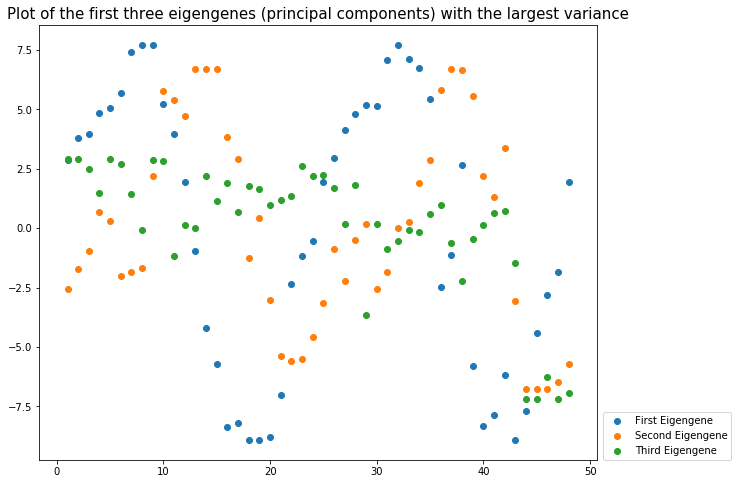

In [16]:
times = np.linspace(1,nc,nc)

eg1 = spca_eigengenes.iloc[:,0]
eg2 = spca_eigengenes.iloc[:,1]
eg3 = spca_eigengenes.iloc[:,2]

plt.figure(figsize=(10,8))
plt.scatter(times, eg1, label="First Eigengene")
plt.scatter(times, eg2, label="Second Eigengene")
plt.scatter(times, eg3, label="Third Eigengene")
plt.title('Plot of the first three eigengenes (principal components) with the largest variance', size=15)
plt.legend(loc=[1.01,0])
plt.show()

Next, plot these three eigengenes against each other:

Text(0.5, 1.0, '2nd vs 3rd')

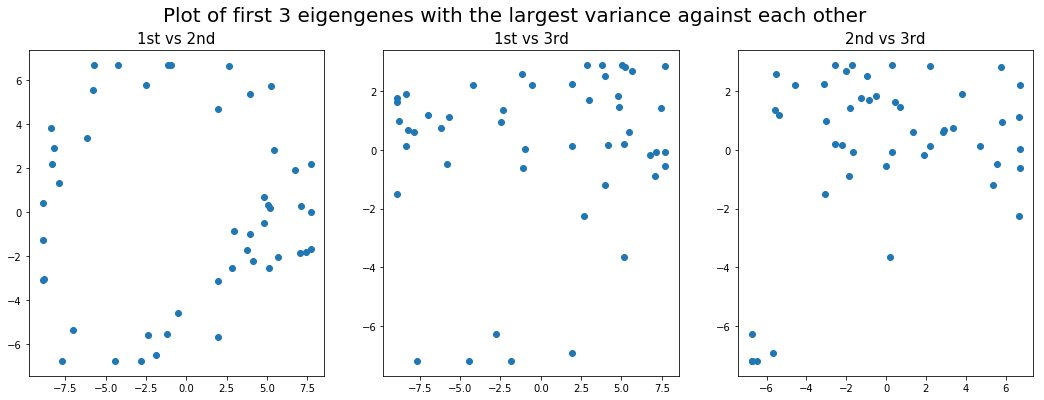

In [17]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (18,6))
plt.suptitle('Plot of first 3 eigengenes with the largest variance against each other', size=20)

ax1.scatter(eg1, eg2)
ax1.set_title('1st vs 2nd', size=15)
ax2.scatter(eg1, eg3)
ax2.set_title('1st vs 3rd', size=15)
ax3.scatter(eg2, eg3)
ax3.set_title('2nd vs 3rd', size=15)

## 4. Creating the autoencoder model

In [18]:
data = spca_eigengenes.to_numpy()

In [19]:
model = cyclops(data.shape[1])

In [20]:
model.model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_layer (InputLayer)        [(None, 9)]          0                                            
__________________________________________________________________________________________________
dropout (Dropout)               (None, 9)            0           input_layer[0][0]                
__________________________________________________________________________________________________
hidden_input (Dense)            (None, 5)            50          dropout[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 5)            0           hidden_input[0][0]               
_______________________________________________________________________________________

### Training the model

In [21]:
history = model.train(data[np.random.permutation(data.shape[0]), :], epochs=300, verbose=50, batch_size=10)

epoch: 50/300, loss: -0.5690, time elapsed:  0.96s, time left:  4.81s
epoch: 100/300, loss: -0.5667, time elapsed:  1.24s, time left:  2.49s
epoch: 150/300, loss: -0.5832, time elapsed:  1.53s, time left:  1.53s
epoch: 200/300, loss: -0.5571, time elapsed:  1.80s, time left:  0.90s
epoch: 250/300, loss: -0.5364, time elapsed:  2.08s, time left:  0.42s
epoch: 300/300, loss: -0.5313, time elapsed:  2.36s, time left:  0.00s


#### Plot the loss of the model to check if it has converged:

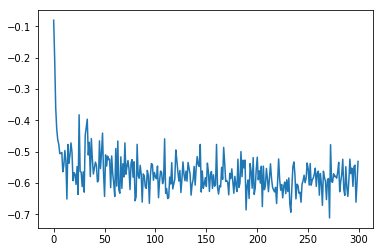

In [22]:
plt.plot(history.history['loss'])

## 5. Results and analysis

Print a dataframe of phase values generated from the autoencoder, and sort the rows according to increasing pseudotime values:

In [23]:
phase_df = model.phase_output(data)
phase_df.head()

,pseudotime
9,-3.040311
10,-2.932802
11,-2.855016
37,-2.671442
36,-2.002015


#### $z_p$ and $z_q$ are the values of each circular node in the bottleneck layer, from which the pseudotime (phase) values were extracted using argtan operations.

Next, print the lists of indices (which are the sample collection times) and phase values:

In [24]:
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()
phase_idx, phase_list

(array([ 9, 10, 11, 37, 36, 12, 35, 13, 14, 38, 15, 41, 39, 16, 40, 18, 17,
        42, 19, 20, 43, 44, 45, 46, 21, 23, 22, 47, 24, 25,  0, 26,  1,  7,
        30,  2, 29, 27,  6, 28, 31, 32,  4, 33,  8,  3,  5, 34]),
 array([-3.0403109 , -2.9328017 , -2.8550155 , -2.671442  , -2.0020154 ,
        -1.9454734 , -1.8358605 , -1.7862915 , -1.6413577 , -1.5254778 ,
        -1.3915743 , -1.3184276 , -1.1844715 , -1.1653898 , -1.0498775 ,
        -0.9384325 , -0.8415379 , -0.7994995 , -0.79622453, -0.4927009 ,
        -0.30185738,  0.24098735,  0.80721354,  0.90788835,  0.9131766 ,
         1.0013715 ,  1.0890789 ,  1.339417  ,  1.5719304 ,  1.8360057 ,
         1.8460547 ,  1.8615305 ,  1.9400351 ,  2.0027905 ,  2.0557175 ,
         2.059053  ,  2.0830631 ,  2.1074514 ,  2.1259036 ,  2.2071316 ,
         2.2393332 ,  2.2637334 ,  2.3898551 ,  2.4155517 ,  2.4271488 ,
         2.4752247 ,  2.6846583 ,  2.7810287 ], dtype=float32))

### Plotting

Produce a polar plot of phase values:

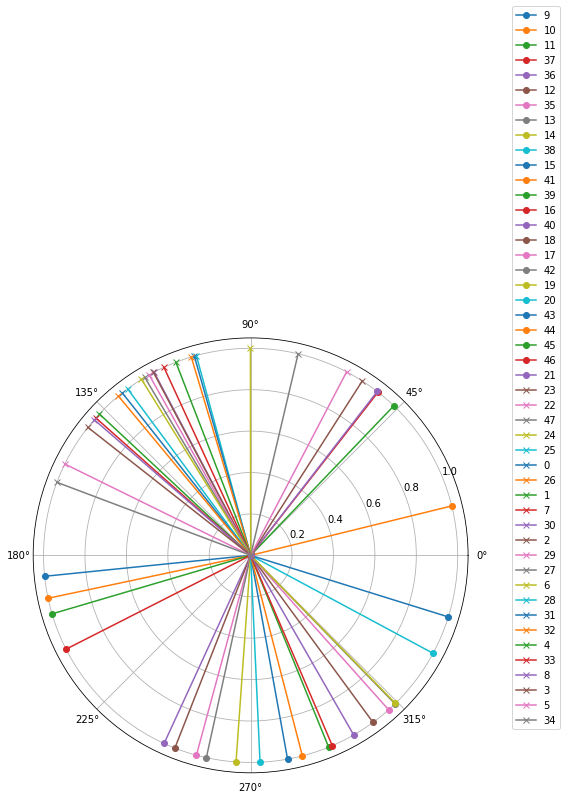

In [25]:
model.plot_polar(nc, phase_idx, phase_list)

#### Adjust and wrap phase values such that the phase at the first collection time (time 0) is zero:

In [26]:
idx = list(phase_idx).index(0)
phase_list -= phase_list[idx]

for i in range(len(phase_list)):
    if phase_list[i] > np.pi:
        phase_list[i] = -np.pi + (phase_list[i]-np.pi)
    elif phase_list[i] < -np.pi:
        phase_list[i] = np.pi - (-np.pi-phase_list[i])
        
phase_list

array([ 1.39682   ,  1.5043291 ,  1.582115  ,  1.7656888 ,  2.435115  ,
        2.491657  ,  2.60127   ,  2.650839  ,  2.7957728 ,  2.9116528 ,
        3.0455563 ,  3.1187031 , -3.0305262 , -3.0114446 , -2.8959322 ,
       -2.7844872 , -2.6875925 , -2.645554  , -2.6422791 , -2.3387556 ,
       -2.147912  , -1.6050674 , -1.0388411 , -0.9381663 , -0.9328781 ,
       -0.8446832 , -0.75697577, -0.5066377 , -0.27412426, -0.01004899,
        0.        ,  0.01547587,  0.09398043,  0.15673578,  0.2096628 ,
        0.21299827,  0.23700845,  0.26139677,  0.27984893,  0.36107695,
        0.39327848,  0.4176787 ,  0.5438005 ,  0.569497  ,  0.58109415,
        0.62917006,  0.8386036 ,  0.9349741 ], dtype=float32)

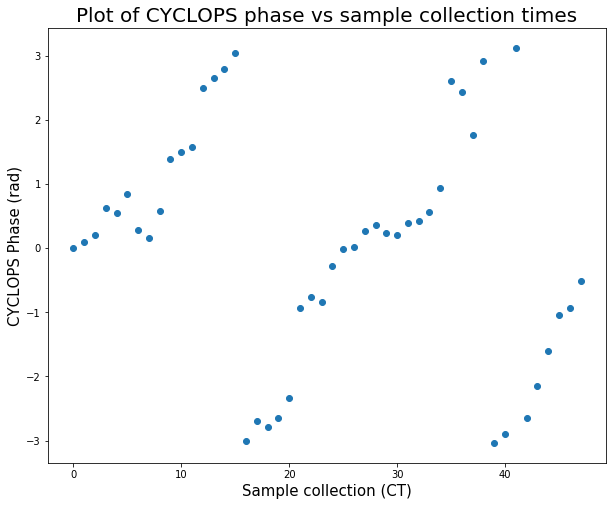

In [27]:
model.plot_phase_time(phase_idx, phase_list)

### Remapping

Create a dictionary of remapped sample indices according to increasing phase values:

In [28]:
remap_dict = model.remap(nc,phase_idx)

### Processing

#### Re-ordering the samples from the original dataset:

In [29]:
ori = df.to_numpy().T

new = np.zeros([ng,nc])
for i in range(ng):
    for key, val in remap_dict.items():
        new[i][val-1] = ori[i][key-1]

In [30]:
new.shape

(9471, 48)

#### Define a sinusoidal function to fit the reordered gene expressions. The function takes 4 parameters: intercept, amplitude, frequency and phase difference:

In [31]:
def test_func(x, dist, amp, omega, phi):
    return dist + amp * np.sin(omega * x + phi)

#### Create a curve fitting function that fits an optimal sinusoid to expression data for every gene:

In [32]:
from scipy import optimize
def fit_(f, xdata, ydata):
    try:
        popt, pcov = optimize.curve_fit(f, xdata, ydata)

        #Residual sum of squares (ss_res):
        residuals = ydata- f(xdata, *popt)
        ss_res = np.sum(residuals**2)

        #Total sum of squares (ss_tot):
        ss_tot = np.sum((ydata-np.mean(ydata))**2)

        r_squared = 1 - (ss_res / ss_tot)   
            
        return popt, pcov, r_squared

    except:
        pass

#### Store the parameter, covariance and $R^2$ values in arrays:

In [33]:
%%time

params, pcov = np.zeros([ng,4]), np.zeros([ng,4,4])
r_squared = np.zeros(ng)

for i in range(ng):
    try:
        params[i] = fit_(test_func, phase_list, new[i])[0]
        pcov[i] = fit_(test_func, phase_list, new[i])[1]
        r_squared[i] = fit_(test_func, phase_list, new[i])[2]
    except:
        continue

CPU times: user 52.4 s, sys: 101 ms, total: 52.5 s
Wall time: 52.6 s


In [34]:
params.shape, pcov.shape, r_squared.shape

((9471, 4), (9471, 4, 4), (9471,))

####  Create a dataframe of parameter and $R^2$ values and print:

_Note: if optimal parameters cannot be found for a particular gene, the parameter and $R^2$ values will be zero._

In [35]:
df_params = pd.DataFrame(params, columns=['intercept', 'amplitude', 'frequency', 'phase_shift'])
df_params['r_squared'] = r_squared

Sort the dataframe in descending order of $R^2$ values:

In [36]:
df_params = df_params.sort_values(by='r_squared', ascending = False)
df_params.head()

,intercept,amplitude,frequency,phase_shift,r_squared
953,10.904243,1.271158,0.988195,0.599608,0.947223
2107,9.892154,0.531229,1.003481,0.788661,0.934145
7062,7.761372,1.176214,0.911607,1.413265,0.925883
6422,11.184224,1.637893,0.991940,0.574488,0.923474
8296,9.858686,1.532461,0.918738,1.006300,0.921952


#### Plot the expression for the top 9 genes with the highest $R^2$ values:

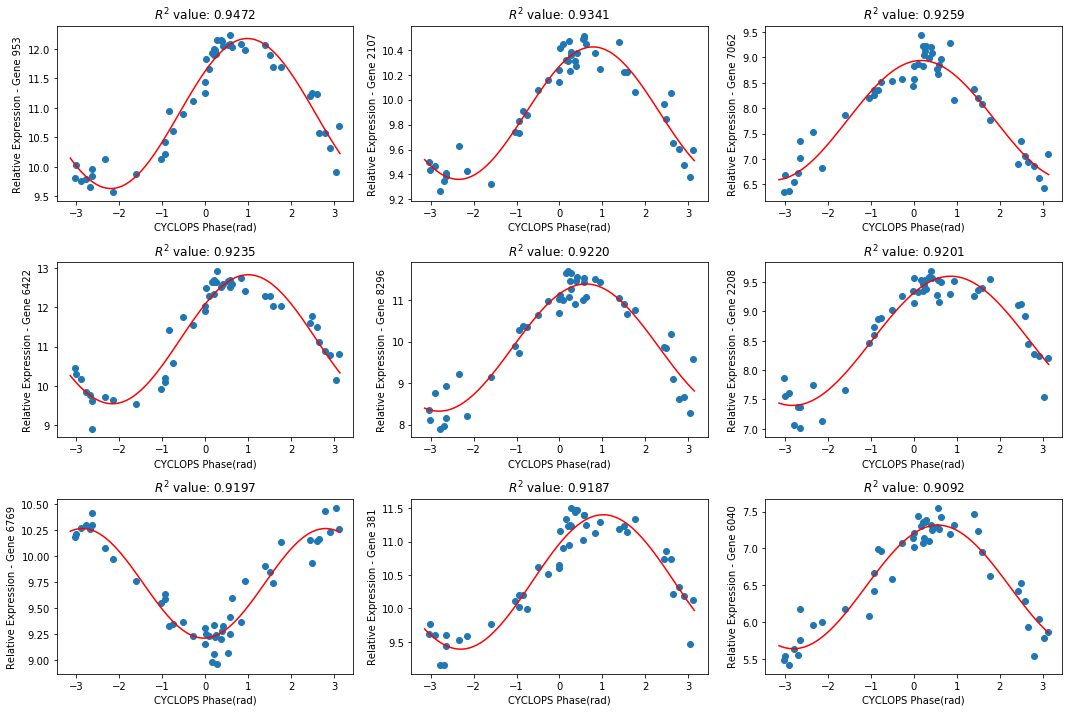

In [37]:
x = np.linspace(-np.pi,np.pi,100)

fig = plt.figure(figsize=(15,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.scatter(phase_list, new[df_params.index[i]])
    plt.plot(x, df_params.intercept.iloc[i]+df_params.amplitude.iloc[i]*np.sin(df_params.frequency.iloc[i]*x+df_params.phase_shift.iloc[i]), c='red')        
    plt.xlabel('CYCLOPS Phase(rad)')
    plt.ylabel('Relative Expression - Gene {}'.format(df_params.index[i]))
    plt.title('$R^2$ value: {:.4f}'.format(df_params.r_squared.iloc[i]))
    plt.tight_layout()

### Evaluating fit using R^2 values

#### Print the collection time indices reordered according to increasing index collection time values:

In [38]:
phase_df = model.phase_output(data)
phase_idx = phase_df.index.to_numpy()
phase_list = phase_df.pseudotime.to_numpy()

re_phase_idx = phase_df.sort_index().index.to_numpy()
re_phase_list = phase_df.sort_index()['pseudotime'].to_numpy()

re_phase_idx, re_phase_list

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]),
 array([ 1.8460547 ,  1.9400351 ,  2.059053  ,  2.4752247 ,  2.3898551 ,
         2.6846583 ,  2.1259036 ,  2.0027905 ,  2.4271488 , -3.0403109 ,
        -2.9328017 , -2.8550155 , -1.9454734 , -1.7862915 , -1.6413577 ,
        -1.3915743 , -1.1653898 , -0.8415379 , -0.9384325 , -0.79622453,
        -0.4927009 ,  0.9131766 ,  1.0890789 ,  1.0013715 ,  1.5719304 ,
         1.8360057 ,  1.8615305 ,  2.1074514 ,  2.2071316 ,  2.0830631 ,
         2.0557175 ,  2.2393332 ,  2.2637334 ,  2.4155517 ,  2.7810287 ,
        -1.8358605 , -2.0020154 , -2.671442  , -1.5254778 , -1.1844715 ,
        -1.0498775 , -1.3184276 , -0.7994995 , -0.30185738,  0.24098735,
         0.80721354,  0.90788835,  1.339417  ], dtype=float32))

#### Determine the indices of phase jumps (in either direction) of absolute value greater than pi:

In [39]:
asc_phase_jump, desc_phase_jump = [],[]
for i in range(len(re_phase_list)-1):
    if re_phase_list[i+1]-re_phase_list[i] > np.pi:
        desc_phase_jump.append(i)
    elif re_phase_list[i+1]-re_phase_list[i] < -np.pi:
        asc_phase_jump.append(i)
        
asc_phase_jump, desc_phase_jump

([8, 34], [])

#### Function to remove anomalous jumps caused by noise in reorderings:

In [40]:
def jump_control(X):
    X_ = X.copy()
    pop_list = []
    
    margin = 10
    for i in range(1,len(X)):
        if X[i]-X[i-1]<margin:
            pop_list.append(i)
    pop_list.sort(reverse=True)
    for i in pop_list:
        X_.pop(i)
    return X_

In [41]:
if len(asc_phase_jump) > len(desc_phase_jump):
    phase_jump = asc_phase_jump
else:
    phase_jump = desc_phase_jump
    

phase_jump = jump_control(phase_jump)
phase_jump 

[8, 34]

#### Phase plots with red markers for identified jumps:

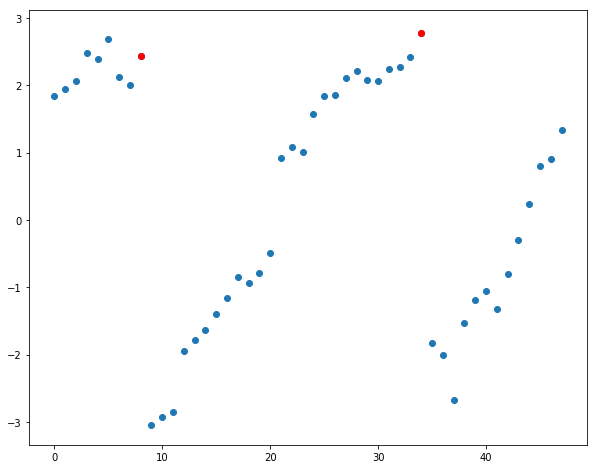

In [42]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.scatter(re_phase_idx[phase_jump], re_phase_list[phase_jump], marker='o', color="red")
plt.show()

#### Increment or decrement values in the phase list by 2pi based on the sign of the phase jumps:

In [43]:
jumps = len(phase_jump)
for i in range(jumps):
    if len(asc_phase_jump) > len(desc_phase_jump):
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] + 2*np.pi for i in range(nc)])
    else:
        re_phase_list = np.array([re_phase_list[i] if i < phase_jump[0]+1 else re_phase_list[i] - 2*np.pi for i in range(nc)])
    phase_jump.pop(0)

#### Linear regression:

In [44]:
from scipy.stats import linregress

lin = linregress(re_phase_idx, re_phase_list)
lin

LinregressResult(slope=0.25869190544217424, intercept=1.0849471084153972, rvalue=0.9908790010259593, pvalue=1.0740401110163696e-41, stderr=0.005187127646844972)

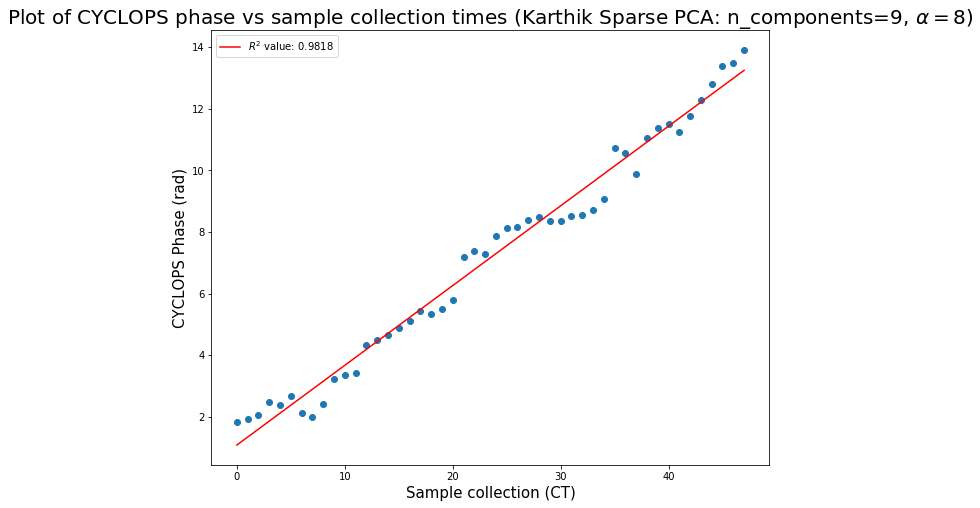

In [45]:
plt.figure(figsize=(10,8))
plt.scatter(re_phase_idx, re_phase_list)
plt.plot(re_phase_idx, lin[0]*re_phase_idx + lin[1], color='red', label='$R^2$ value: {:.4f}'.format(lin[2]**2))
plt.title(r'Plot of CYCLOPS phase vs sample collection times (Karthik Sparse PCA: n_components={}, $\alpha={}$)'.format(n_components, alpha), size=20)
plt.xlabel('Sample collection (CT)', size=15)
plt.ylabel('CYCLOPS Phase (rad)', size=15)
plt.legend()
plt.show()